# Import libraries

In [1]:
import datetime as datetime
from feature_extraction.indicator_features import *
from feature_extraction.price_features import *
from feature_extraction.trader_features import *
import matplotlib.pyplot as plt
from models.model import *
import mplfinance as mpf
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500)
import pytse_client as tse
from pytse_client.download import download_financial_indexes
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
from zigzag_indicator.zigzag import peak_valley_pivots

# Import data

In [2]:
tse.download(
    symbols = ['فولاد'],
    adjust = True, 
    write_to_csv = True, 
    include_jdate = True
)
ticker = tse.Ticker(
    symbol = 'فولاد',  
    adjust = True
)
ticker_history = ticker.history

ticker_history = ticker_history[ticker_history.columns[:-1].insert(0, ticker_history.columns[-1]).to_list()] # change location of jdate

print(f'Shape of Folad price history: {ticker_history.shape}')
print(50 * '-')
print(f'{ticker_history.info()}')
print(50 * '-')
ticker_history.head()

Shape of Folad price history: (3511, 11)
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3511 entries, 0 to 3510
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   jdate      3511 non-null   object        
 1   date       3511 non-null   datetime64[ns]
 2   open       3511 non-null   float64       
 3   high       3511 non-null   float64       
 4   low        3511 non-null   float64       
 5   adjClose   3511 non-null   float64       
 6   value      3511 non-null   int64         
 7   volume     3511 non-null   int64         
 8   count      3511 non-null   int64         
 9   yesterday  3511 non-null   float64       
 10  close      3511 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int64(3), object(1)
memory usage: 301.9+ KB
None
--------------------------------------------------


,jdate,date,open,high,low,adjClose,value,volume,count,yesterday,close
0,1385-12-20,2007-03-11,16.0,16.0,16.0,16.0,889437216900,468077431,7736,16.0,16.0
1,1385-12-21,2007-03-12,16.0,16.0,16.0,16.0,193879458000,100041000,9214,16.0,16.0
2,1385-12-22,2007-03-13,16.0,16.0,16.0,16.0,249241504527,126270939,5862,16.0,16.0
3,1385-12-23,2007-03-14,16.0,16.0,16.0,16.0,51666379451,26705128,1901,16.0,16.0
4,1385-12-26,2007-03-17,16.0,16.0,16.0,16.0,28239006789,14877283,1514,16.0,16.0


In [3]:
ticker_traders_types = ticker.client_types
ticker_traders_types = ticker_traders_types.iloc[::-1]
ticker_traders_types.reset_index(
    drop = True,
    inplace = True
)
ticker_traders_types['date'] = ticker_traders_types['date'].apply(
    lambda x: datetime.datetime.strptime(x, '%Y%m%d')
)
ticker_traders_types.iloc[:, 1:] = ticker_traders_types.iloc[:, 1:].astype('float')

print(f"Shape of Folad's client history: {ticker_traders_types.shape}")
print(50 * '-')
print(f'{ticker_traders_types.info()}')
print(50 * '-')
ticker_traders_types.head()

Shape of Folad's client history: (3126, 18)
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3126 entries, 0 to 3125
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   date                         3126 non-null   datetime64[ns]
 1   individual_buy_count         3126 non-null   float64       
 2   corporate_buy_count          3126 non-null   float64       
 3   individual_sell_count        3126 non-null   float64       
 4   corporate_sell_count         3126 non-null   float64       
 5   individual_buy_vol           3126 non-null   float64       
 6   corporate_buy_vol            3126 non-null   float64       
 7   individual_sell_vol          3126 non-null   float64       
 8   corporate_sell_vol           3126 non-null   float64       
 9   individual_buy_value         3126 non-null   float64       
 10  corporate_buy

,date,individual_buy_count,corporate_buy_count,individual_sell_count,corporate_sell_count,individual_buy_vol,corporate_buy_vol,individual_sell_vol,corporate_sell_vol,individual_buy_value,corporate_buy_value,individual_sell_value,corporate_sell_value,individual_buy_mean_price,individual_sell_mean_price,corporate_buy_mean_price,corporate_sell_mean_price,individual_ownership_change
0,2008-11-26,14.0,2.0,4.0,1.0,106338.0,20010.0,126338.0,10.0,2.489373e+08,4.684412e+07,295757258.0,2.412000e+04,2341.000000,2341.0,2341.035482,2412.000000,-20000.0
1,2008-11-29,116.0,175.0,3.0,2.0,4718258.0,33691903.0,121402.0,38288759.0,1.498023e+10,1.077130e+11,284080680.0,1.224092e+11,3174.949168,2340.0,3196.999767,3196.999795,4596856.0
2,2008-11-30,10.0,2.0,1.0,1.0,87219.0,12791.0,100000.0,10.0,2.040052e+08,2.991886e+07,233900000.0,2.410000e+04,2339.000000,2339.0,2339.055508,2410.000000,-12781.0
3,2008-12-01,8.0,1.0,5.0,1.0,128666.0,10.0,128666.0,10.0,3.008211e+08,2.409000e+04,300821108.0,2.409000e+04,2338.000000,2338.0,2409.000000,2409.000000,0.0
4,2008-12-02,7.0,1.0,1.0,0.0,18553.0,10000.0,28553.0,0.0,4.335836e+07,2.337000e+07,66728361.0,0.000000e+00,2337.000000,2337.0,2337.000000,NaN,-10000.0


In [4]:
market_index = download_financial_indexes(
    symbols = 'شاخص كل', 
    write_to_csv = True
)
market_index = market_index['شاخص كل']
market_index.rename(
    columns = {'value': 'TEDPIX'}, 
    inplace = True
)

print(f'Shape of TEDPIX: {market_index.shape}')
market_index.head()

Shape of TEDPIX: (3425, 2)


,TEDPIX,date
0,9248.9,2008-12-04
1,9248.9,2008-12-05
2,9178.3,2008-12-06
3,9130.5,2008-12-07
4,9089.2,2008-12-08


In [5]:
ticker_history = ticker_history.merge(
    market_index, 
    how = 'left', 
    on = 'date'
)
ticker_history.head()

,jdate,date,open,high,low,adjClose,value,volume,count,yesterday,close,TEDPIX
0,1385-12-20,2007-03-11,16.0,16.0,16.0,16.0,889437216900,468077431,7736,16.0,16.0,NaN
1,1385-12-21,2007-03-12,16.0,16.0,16.0,16.0,193879458000,100041000,9214,16.0,16.0,NaN
2,1385-12-22,2007-03-13,16.0,16.0,16.0,16.0,249241504527,126270939,5862,16.0,16.0,NaN
3,1385-12-23,2007-03-14,16.0,16.0,16.0,16.0,51666379451,26705128,1901,16.0,16.0,NaN
4,1385-12-26,2007-03-17,16.0,16.0,16.0,16.0,28239006789,14877283,1514,16.0,16.0,NaN


In [6]:
# # plt.figure(figsize = (10, 50))
# # plt.tight_layout()
# dff = ticker_history[['date', 'open', 'high', 'low', 'close','volume']].set_index('date')

# fig, ax = mpf.plot(
#     dff,
#     title = 'Mobarakeh Steel  Stock Price',
#     volume = True,
#     type = 'candle',
#     # style = 'yahoo',
#     figratio = (18,10),
#     figscale = 1.5,
#     datetime_format = '%Y-%m-%d',
#     # marketcolor_overrides = ,
#     tight_layout = True,
#     returnfig=True
#     # tight_layout = True
# )
# ax = ax[0]
# ax.set_yscale('log')

In [7]:
# def plot_chart(data, n, ticker):
    
#     # Filter number of observations to plot
#     data = data.iloc[-n:]
    
#     # Create figure and set axes for subplots
#     fig = plt.figure()
#     fig.set_size_inches((20, 16))
#     ax_candle = fig.add_axes((0, 0.72, 1, 0.32))
#     ax_macd = fig.add_axes((0, 0.48, 1, 0.2), sharex=ax_candle)
#     ax_rsi = fig.add_axes((0, 0.24, 1, 0.2), sharex=ax_candle)
#     ax_vol = fig.add_axes((0, 0, 1, 0.2), sharex=ax_candle)
    
#     # Format x-axis ticks as dates
#     ax_candle.xaxis_date()
    
#     # Get nested list of date, open, high, low and close prices
#     ohlc = []
#     for date, row in data.iterrows():
#         openp, highp, lowp, closep = row[:4]
#         ohlc.append([date2num(date), openp, highp, lowp, closep])
 
#     # Plot candlestick chart
#     ax_candle.plot(data.index, data["ma10"], label="MA10")
#     ax_candle.plot(data.index, data["ma30"], label="MA30")
#     candlestick_ohlc(ax_candle, ohlc, colorup="g", colordown="r", width=0.8)
#     ax_candle.legend()
    
#     # Plot MACD
#     ax_macd.plot(data.index, data["macd"], label="macd")
#     ax_macd.bar(data.index, data["macd_hist"] * 3, label="hist")
#     ax_macd.plot(data.index, data["macd_signal"], label="signal")
#     ax_macd.legend()
    
#     # Plot RSI
#     # Above 70% = overbought, below 30% = oversold
#     ax_rsi.set_ylabel("(%)")
#     ax_rsi.plot(data.index, [70] * len(data.index), label="overbought")
#     ax_rsi.plot(data.index, [30] * len(data.index), label="oversold")
#     ax_rsi.plot(data.index, data["rsi"], label="rsi")
#     ax_rsi.legend()
    
#     # Show volume in millions
#     ax_vol.bar(data.index, data["Volume"] / 1000000)
#     ax_vol.set_ylabel("(Million)")
   
#     # Save the chart as PNG
#     fig.savefig("charts/" + ticker + ".png", bbox_inches="tight")
    
#     plt.show()

# Features

In [8]:
calenderFeatures = calender_features(ticker_history)
candelFeatures = candlestick_feature(ticker_history)
prpFeatures = prp_based(ticker_history)
retFeatures = ret_based(ticker_history)
shiftFeatures = shift_data(ticker_history)
wghtFeatures = weight_feature(ticker_history)

priceFeatures = pd.concat(
    [
        ticker_history,
        calenderFeatures,
        candelFeatures,
        prpFeatures,
        retFeatures,
        shiftFeatures,
        wghtFeatures
    ], axis = 1
)

print(f'Shape of price features: {priceFeatures.shape}')
priceFeatures.head()

Shape of price features: (3511, 131)


,jdate,date,open,high,low,adjClose,value,volume,count,yesterday,close,TEDPIX,year,quarter,month,day,weekday,shadow_up_1w,shadow_low_1w,body_1w,mean_to_shadow_up_1w,mean_to_shadow_low_1w,shadow_up_2w,shadow_low_2w,body_2w,mean_to_shadow_up_2w,mean_to_shadow_low_2w,shadow_up_3w,shadow_low_3w,body_3w,mean_to_shadow_up_3w,mean_to_shadow_low_3w,shadow_up_1m,shadow_low_1m,body_1m,mean_to_shadow_up_1m,mean_to_shadow_low_1m,shadow_up_3m,shadow_low_3m,body_3m,mean_to_shadow_up_3m,mean_to_shadow_low_3m,max_price_1w,min_price_1w,mean_price_1w,first_price_1w,last_price_1w,yesterday_price_1w,max_price_2w,min_price_2w,mean_price_2w,first_price_2w,last_price_2w,yesterday_price_2w,max_price_3w,min_price_3w,mean_price_3w,first_price_3w,last_price_3w,yesterday_price_3w,max_price_1m,min_price_1m,mean_price_1m,first_price_1m,last_price_1m,yesterday_price_1m,max_price_3m,min_price_3m,mean_price_3m,first_price_3m,last_price_3m,yesterday_price_3m,prp_high_1m,prp_high_3m,prp_value_1w1m,prp_value_2w3m,prp_value_3w3m,prp_value_1m3m,ret_1d,ret_3d,ret_1w,ret_2w,ret_1m,ret_3m,ret_1d_log,ret_3d_log,ret_1w_log,ret_2w_log,ret_1m_log,ret_3m_log,buy_queue_locked,sell_queue_locked,last1d_open,last1d_high,last1d_low,last1d_adjClose,last1d_value,last1d_volume,last1d_count,last1d_yesterday,last1d_close,last1d_TEDPIX,last5d_open,last5d_high,last5d_low,last5d_adjClose,last5d_value,last5d_volume,last5d_count,last5d_yesterday,last5d_close,last5d_TEDPIX,value_20d,value_30d,value_40d,value_50d,value_60d,value_70d,value_80d,value_90d,value_100d,value_weight,value_weight_20d,value_weight_30d,value_weight_40d,value_weight_50d,value_weight_60d,value_weight_70d,value_weight_80d,value_weight_90d,value_weight_100d
0,1385-12-20,2007-03-11,16.0,16.0,16.0,16.0,889437216900,468077431,7736,16.0,16.0,NaN,1385,4,12,20,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,-0.0625,0.0,0.0,0.0625,0.0,-0.0625,0.0,0.0,0.0625,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0,15.0,16.0,16.0,16.0,16.0,16.0,15.0,16.0,16.0,16.0,16.0,1.066667,1.066667,NaN,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000616,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1385-12-21,2007-03-12,16.0,16.0,16.0,16.0,193879458000,100041000,9214,16.0,16.0,NaN,1385,4,12,21,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,-0.0625,0.0,0.0,0.0625,0.0,-0.0625,0.0,0.0,0.0625,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0,15.0,16.0,16.0,16.0,16.0,16.0,15.0,16.0,16.0,16.0,16.0,1.066667,1.066667,NaN,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0,0,16.0,16.0,16.0,16.0,8.894372e+11,468077431.0,7736.0,16.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000134,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1385-12-22,2007-03-13,16.0,16.0,16.0,16.0,249241504527,126270939,5862,16.0,16.0,NaN,1385,4,12,22,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,-0.0625,0.0,0.0,0.0625,0.0,-0.0625,0.0,0.0,0.0625,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0,15.0,16.0,16.0,16.0,16.0,16.0,15.0,16.0,16.0,16.0,16.0,1.066667,1.066667,NaN,NaN,NaN,1.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0,0,16.0,16.0,16.0,16.0,1.938795e+11,100041000.0,9214.0,16.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000173,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1385-12-23,2007-03-14,16.0,16.0,16.0,16.0,51666379451,26705128,1901,16.0,16.0,NaN,1385,4,12,23,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,-0.0625,0.0,0.0,0.0625,0.0,-0.0625,0.0,0.0,0.0625,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0,15.0,16.0,16.0,16.0,16.0,16.0,15.0,16.0,16.0,16.0,16.0,1.066667,1.066667,NaN,NaN,NaN,1.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0,0,16.0,16.0,16.0,16.0,2.492415e+11,126270939

In [9]:
traderFeatures = ticker_traders_types.merge(
    indv_nonindv_features(ticker_traders_types),
    how = 'left',
    on = 'date'
)

print(f'Shape of trader features: {traderFeatures.shape}')
traderFeatures.head()

Shape of trader features: (3126, 42)


,date,individual_buy_count,corporate_buy_count,individual_sell_count,corporate_sell_count,individual_buy_vol,corporate_buy_vol,individual_sell_vol,corporate_sell_vol,individual_buy_value,corporate_buy_value,individual_sell_value,corporate_sell_value,individual_buy_mean_price,individual_sell_mean_price,corporate_buy_mean_price,corporate_sell_mean_price,individual_ownership_change,enter_indv_money,indv_buy_per_capita,indv_sell_per_capita,indv_power,enter_indv_money_1w,indv_buy_per_capita_daily_to_1w,indv_sell_per_capita_daily_to_1w,indv_power_daily_to_1w,enter_indv_money_2w,indv_buy_per_capita_daily_to_2w,indv_sell_per_capita_daily_to_2w,indv_power_daily_to_2w,enter_indv_money_3w,indv_buy_per_capita_daily_to_3w,indv_sell_per_capita_daily_to_3w,indv_power_daily_to_3w,enter_indv_money_1m,indv_buy_per_capita_daily_to_1m,indv_sell_per_capita_daily_to_1m,indv_power_daily_to_1m,enter_indv_money_3m,indv_buy_per_capita_daily_to_3m,indv_sell_per_capita_daily_to_3m,indv_power_daily_to_3m
0,2008-11-26,14.0,2.0,4.0,1.0,106338.0,20010.0,126338.0,10.0,2.489373e+08,4.684412e+07,295757258.0,2.412000e+04,2341.000000,2341.0,2341.035482,2412.000000,-20000.0,-4.682000e+07,1.778123e+07,73939314.5,0.240484,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.281292e+10,0.646302,1.209462,0.392173,-1.281292e+10,0.646302,1.209462,0.392173
1,2008-11-29,116.0,175.0,3.0,2.0,4718258.0,33691903.0,121402.0,38288759.0,1.498023e+10,1.077130e+11,284080680.0,1.224092e+11,3174.949168,2340.0,3196.999767,3196.999795,4596856.0,1.469615e+10,1.291399e+08,94693560.0,1.363767,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.281292e+10,4.693901,1.548950,2.223985,-1.281292e+10,4.693901,1.548950,2.223985
2,2008-11-30,10.0,2.0,1.0,1.0,87219.0,12791.0,100000.0,10.0,2.040052e+08,2.991886e+07,233900000.0,2.410000e+04,2339.000000,2339.0,2339.055508,2410.000000,-12781.0,-2.989476e+07,2.040052e+07,233900000.0,0.087219,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.281292e+10,0.741506,3.826019,0.142234,-1.281292e+10,0.741506,3.826019,0.142234
3,2008-12-01,8.0,1.0,5.0,1.0,128666.0,10.0,128666.0,10.0,3.008211e+08,2.409000e+04,300821108.0,2.409000e+04,2338.000000,2338.0,2409.000000,2409.000000,0.0,0.000000e+00,3.760264e+07,60164221.6,0.625000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.281292e+10,1.366759,0.984136,1.019229,-1.281292e+10,1.366759,0.984136,1.019229
4,2008-12-02,7.0,1.0,1.0,0.0,18553.0,10000.0,28553.0,0.0,4.335836e+07,2.337000e+07,66728361.0,0.000000e+00,2337.000000,2337.0,2337.000000,NaN,-10000.0,-2.337000e+07,6.194052e+06,66728361.0,0.092825,1.459606e+10,0.146696,0.630196,0.192639,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.281292e+10,0.225138,1.091509,0.151376,-1.281292e+10,0.225138,1.091509,0.151376


In [10]:
bbFeatures = BB(ticker_history)
ichiFeatures = ICHIMOKU(ticker_history)
emaFeatures = EMA(ticker_history)
macdFeatures = MACD(ticker_history)
smaFeatures = SMA(ticker_history)
stochasticFeatures = STOCHASTIC(ticker_history)
rsiFeatures = RSI(ticker_history)

indicatorFeatures = pd.concat(
    [
        bbFeatures,
        ichiFeatures,
        emaFeatures,
        macdFeatures,
        smaFeatures,
        stochasticFeatures,
        rsiFeatures,
    ], axis = 1
)

print(f'Shape of indicator features: {indicatorFeatures.shape}')
indicatorFeatures.head()

Shape of indicator features: (3511, 43)


,BB_bbh,BB_bbl,BB_buy,BB_position,Tenkan_Sen,Kijun_Sen,Chikou_Span,Senkou_Span_A,Senkou_Span_B,Tenkan_Kijun_cross_position,Senkou_cross_position,Chikou_adjClose_cross_position,EMA_5d,EMA_5d_diff,last_EMA_5d,EMA_40d,EMA_40d_diff,last_EMA_40d,EMA_buy,EMA_position,MACD,MACD_diff,MACD_signal,MACD_buy,MACD_position,SMA10d,SMA20d,last_SMA20d,SMA30d,SMA50d,last_SMA50d,SMA80d,SMA_buy,SMA_position,STOCH_fast,STOCH_slow,last_STOCH_fast,last_STOCH_slow,STOCH_buy,STOCH_position,RSI,RSI_buy,RSI_position
0,NaN,NaN,NaN,NaN,NaN,NaN,16.0,NaN,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,16.0,NaN,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,16.0,NaN,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,15.0,NaN,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,16.0,NaN,16.0,NaN,NaN,NaN,16.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
features_extracted = pd.concat(
    [
        priceFeatures,
        indicatorFeatures
    ],
    axis = 1
)
features_extracted = features_extracted.merge(
    traderFeatures,
    how = 'right',
    on = 'date'
)
print(f'shape of features after concatenation: {features_extracted.shape}')

features_extracted.dropna(
    axis = 'columns', 
    thresh = len(features_extracted) - 385,
    inplace = True
)
print(f'shape of features after drop non-essential columns: {features_extracted.shape}')
print(f'names of the columns that dropped: {(indicatorFeatures.columns.union(priceFeatures.columns)).difference(features_extracted.columns).to_list()}')

features_extracted.dropna(
    axis = 'index', 
    how = 'any',
    inplace = True
)
print(f'shape of features after drop non-essential rows: {features_extracted.shape}')
features_extracted.head()

shape of features after concatenation: (3126, 215)
shape of features after drop non-essential columns: (3126, 209)
names of the columns that dropped: ['BB_buy', 'EMA_buy', 'MACD_buy', 'RSI_buy', 'SMA_buy', 'STOCH_buy']
shape of features after drop non-essential rows: (2869, 209)


,jdate,date,open,high,low,adjClose,value,volume,count,yesterday,close,TEDPIX,year,quarter,month,day,weekday,shadow_up_1w,shadow_low_1w,body_1w,mean_to_shadow_up_1w,mean_to_shadow_low_1w,shadow_up_2w,shadow_low_2w,body_2w,mean_to_shadow_up_2w,mean_to_shadow_low_2w,shadow_up_3w,shadow_low_3w,body_3w,mean_to_shadow_up_3w,mean_to_shadow_low_3w,shadow_up_1m,shadow_low_1m,body_1m,mean_to_shadow_up_1m,mean_to_shadow_low_1m,shadow_up_3m,shadow_low_3m,body_3m,mean_to_shadow_up_3m,mean_to_shadow_low_3m,max_price_1w,min_price_1w,mean_price_1w,first_price_1w,last_price_1w,yesterday_price_1w,max_price_2w,min_price_2w,mean_price_2w,first_price_2w,last_price_2w,yesterday_price_2w,max_price_3w,min_price_3w,mean_price_3w,first_price_3w,last_price_3w,yesterday_price_3w,max_price_1m,min_price_1m,mean_price_1m,first_price_1m,last_price_1m,yesterday_price_1m,max_price_3m,min_price_3m,mean_price_3m,first_price_3m,last_price_3m,yesterday_price_3m,prp_high_1m,prp_high_3m,prp_value_1w1m,prp_value_2w3m,prp_value_3w3m,prp_value_1m3m,ret_1d,ret_3d,ret_1w,ret_2w,ret_1m,ret_3m,ret_1d_log,ret_3d_log,ret_1w_log,ret_2w_log,ret_1m_log,ret_3m_log,buy_queue_locked,sell_queue_locked,last1d_open,last1d_high,last1d_low,last1d_adjClose,last1d_value,last1d_volume,last1d_count,last1d_yesterday,last1d_close,last1d_TEDPIX,last5d_open,last5d_high,last5d_low,last5d_adjClose,last5d_value,last5d_volume,last5d_count,last5d_yesterday,last5d_close,last5d_TEDPIX,value_20d,value_30d,value_40d,value_50d,value_60d,value_70d,value_80d,value_90d,value_100d,value_weight,value_weight_20d,value_weight_30d,value_weight_40d,value_weight_50d,value_weight_60d,value_weight_70d,value_weight_80d,value_weight_90d,value_weight_100d,BB_bbh,BB_bbl,BB_position,Tenkan_Sen,Kijun_Sen,Chikou_Span,Senkou_Span_A,Senkou_Span_B,Tenkan_Kijun_cross_position,Senkou_cross_position,Chikou_adjClose_cross_position,EMA_5d,EMA_5d_diff,last_EMA_5d,EMA_40d,EMA_40d_diff,last_EMA_40d,EMA_position,MACD,MACD_diff,MACD_signal,MACD_position,SMA10d,SMA20d,last_SMA20d,SMA30d,SMA50d,last_SMA50d,SMA80d,SMA_position,STOCH_fast,STOCH_slow,last_STOCH_fast,last_STOCH_slow,STOCH_position,RSI,RSI_position,individual_buy_count,corporate_buy_count,individual_sell_count,corporate_sell_count,individual_buy_vol,corporate_buy_vol,individual_sell_vol,corporate_sell_vol,individual_buy_value,corporate_buy_value,individual_sell_value,corporate_sell_value,individual_buy_mean_price,individual_sell_mean_price,corporate_buy_mean_price,corporate_sell_mean_price,individual_ownership_change,enter_indv_money,indv_buy_per_capita,indv_sell_per_capita,indv_power,enter_indv_money_1w,indv_buy_per_capita_daily_to_1w,indv_sell_per_capita_daily_to_1w,indv_power_daily_to_1w,enter_indv_money_2w,indv_buy_per_capita_daily_to_2w,indv_sell_per_capita_daily_to_2w,indv_power_daily_to_2w,enter_indv_money_3w,indv_buy_per_capita_daily_to_3w,indv_sell_per_capita_daily_to_3w,indv_power_daily_to_3w,enter_indv_money_1m,indv_buy_per_capita_daily_to_1m,indv_sell_per_capita_daily_to_1m,indv_power_daily_to_1m,enter_indv_money_3m,indv_buy_per_capita_daily_to_3m,indv_sell_per_capita_daily_to_3m,indv_power_daily_to_3m
100,1388-02-14,2009-05-04,14.0,15.0,14.0,15.0,3759836863,2080737,204,15.0,15.0,8638.3,1388,1,2,14,2,0.0,-0.066667,0.0000,0.000000,0.066667,0.0,-0.066667,0.000000,0.00000,0.066667,0.000000,-0.066667,0.000000,0.000000,0.066667,0.0000,-0.066667,0.066667,-0.057576,0.075758,0.071429,0.0,0.214286,-0.189223,0.096491,15.0,14.0,15.0,15.0,15.0,15.0,15.0,14.0,15.0,15.0,15.0,15.0,15.0,14.0,15.000000,15.0,15.0,15.0,16.0,14.0,15.136364,15.0,16.0,15.0,18.0,14.0,15.350877,14.0,17.0,14.0,1.071429,1.071429,0.349193,0.253204,0.326386,0.327252,0.000000,0.000000,0.000000,0.000000,0.004762,-0.045133,0.000000,0.000000,0.000000,0.000000,0.000000,-0.064539,0,0,15.0,15.0,14.0,15.0,2.382522e+09,1358340.0,147.0,15.0,14.0,8584.6,15.0,15.0,15.0,15.0,1.460205e+09,815360.0,122.0,15.0,15.0,8518.1,3.055976e+09,2.308920e+09,2.399035e+09,2.330764e+09,2.478455e+09,3.860871e+09,3.959459e+09,4.427701e+0

In [12]:
pivots = pd.DataFrame(
    peak_valley_pivots(
        ticker_history['adjClose'].to_list(), 0.1
    ) ,
    columns = ['label']
) * -1

print(f'Number of each pivot {np.unique(pivots["label"], return_counts = True)}')

signals = pivots.replace(
    to_replace = 0, 
    value = np.nan
)
signals.fillna(
    method = 'ffill', 
    inplace = True
)
signals.fillna(
    method = 'bfill', 
    inplace = True
)

pivots.columns = ['pivots']
signals['date'] = ticker_history['date']
pivots['date'] = ticker_history['date']

print(f'Number of each class {np.unique(signals["label"], return_counts = True)}')

Number of each pivot (array([-1,  0,  1], dtype=int64), array([ 115, 3281,  115], dtype=int64))
Number of each class (array([-1.,  1.]), array([1930, 1581], dtype=int64))


In [13]:
initFeatures = features_extracted.merge(
    signals,
    how = 'left',
    on = 'date'
)
print(f'Number of initial features: {initFeatures.shape}')
initFeatures

Number of initial features: (2869, 210)


,jdate,date,open,high,low,adjClose,value,volume,count,yesterday,close,TEDPIX,year,quarter,month,day,weekday,shadow_up_1w,shadow_low_1w,body_1w,mean_to_shadow_up_1w,mean_to_shadow_low_1w,shadow_up_2w,shadow_low_2w,body_2w,mean_to_shadow_up_2w,mean_to_shadow_low_2w,shadow_up_3w,shadow_low_3w,body_3w,mean_to_shadow_up_3w,mean_to_shadow_low_3w,shadow_up_1m,shadow_low_1m,body_1m,mean_to_shadow_up_1m,mean_to_shadow_low_1m,shadow_up_3m,shadow_low_3m,body_3m,mean_to_shadow_up_3m,mean_to_shadow_low_3m,max_price_1w,min_price_1w,mean_price_1w,first_price_1w,last_price_1w,yesterday_price_1w,max_price_2w,min_price_2w,mean_price_2w,first_price_2w,last_price_2w,yesterday_price_2w,max_price_3w,min_price_3w,mean_price_3w,first_price_3w,last_price_3w,yesterday_price_3w,max_price_1m,min_price_1m,mean_price_1m,first_price_1m,last_price_1m,yesterday_price_1m,max_price_3m,min_price_3m,mean_price_3m,first_price_3m,last_price_3m,yesterday_price_3m,prp_high_1m,prp_high_3m,prp_value_1w1m,prp_value_2w3m,prp_value_3w3m,prp_value_1m3m,ret_1d,ret_3d,ret_1w,ret_2w,ret_1m,ret_3m,ret_1d_log,ret_3d_log,ret_1w_log,ret_2w_log,ret_1m_log,ret_3m_log,buy_queue_locked,sell_queue_locked,last1d_open,last1d_high,last1d_low,last1d_adjClose,last1d_value,last1d_volume,last1d_count,last1d_yesterday,last1d_close,last1d_TEDPIX,last5d_open,last5d_high,last5d_low,last5d_adjClose,last5d_value,last5d_volume,last5d_count,last5d_yesterday,last5d_close,last5d_TEDPIX,value_20d,value_30d,value_40d,value_50d,value_60d,value_70d,value_80d,value_90d,value_100d,value_weight,value_weight_20d,value_weight_30d,value_weight_40d,value_weight_50d,value_weight_60d,value_weight_70d,value_weight_80d,value_weight_90d,value_weight_100d,BB_bbh,BB_bbl,BB_position,Tenkan_Sen,Kijun_Sen,Chikou_Span,Senkou_Span_A,Senkou_Span_B,Tenkan_Kijun_cross_position,Senkou_cross_position,Chikou_adjClose_cross_position,EMA_5d,EMA_5d_diff,last_EMA_5d,EMA_40d,EMA_40d_diff,last_EMA_40d,EMA_position,MACD,MACD_diff,MACD_signal,MACD_position,SMA10d,SMA20d,last_SMA20d,SMA30d,SMA50d,last_SMA50d,SMA80d,SMA_position,STOCH_fast,STOCH_slow,last_STOCH_fast,last_STOCH_slow,STOCH_position,RSI,RSI_position,individual_buy_count,corporate_buy_count,individual_sell_count,corporate_sell_count,individual_buy_vol,corporate_buy_vol,individual_sell_vol,corporate_sell_vol,individual_buy_value,corporate_buy_value,individual_sell_value,corporate_sell_value,individual_buy_mean_price,individual_sell_mean_price,corporate_buy_mean_price,corporate_sell_mean_price,individual_ownership_change,enter_indv_money,indv_buy_per_capita,indv_sell_per_capita,indv_power,enter_indv_money_1w,indv_buy_per_capita_daily_to_1w,indv_sell_per_capita_daily_to_1w,indv_power_daily_to_1w,enter_indv_money_2w,indv_buy_per_capita_daily_to_2w,indv_sell_per_capita_daily_to_2w,indv_power_daily_to_2w,enter_indv_money_3w,indv_buy_per_capita_daily_to_3w,indv_sell_per_capita_daily_to_3w,indv_power_daily_to_3w,enter_indv_money_1m,indv_buy_per_capita_daily_to_1m,indv_sell_per_capita_daily_to_1m,indv_power_daily_to_1m,enter_indv_money_3m,indv_buy_per_capita_daily_to_3m,indv_sell_per_capita_daily_to_3m,indv_power_daily_to_3m,label
0,1388-02-14,2009-05-04,14.0,15.0,14.0,15.0,3759836863,2080737,204,15.0,15.0,8638.3,1388,1,2,14,2,0.000000,-0.066667,0.000000,0.000000,0.066667,0.000000,-0.066667,0.000000,0.000000,0.066667,0.000000,-0.066667,0.000000,0.000000,0.066667,0.000000,-0.066667,0.066667,-0.057576,0.075758,0.071429,0.000000,0.214286,-0.189223,0.096491,15.0,14.0,15.0,15.0,15.0,15.0,15.0,14.0,15.0,15.0,15.0,15.0,15.0,14.0,15.000000,15.0,15.0,15.0,16.0,14.0,15.136364,15.0,16.0,15.0,18.0,14.0,15.350877,14.0,17.0,14.0,1.071429,1.071429,0.349193,0.253204,0.326386,0.327252,0.000000,0.000000,0.000000,0.000000,0.004762,-0.045133,0.000000,0.000000,0.000000,0.000000,0.000000,-0.064539,0,0,15.0,15.0,14.0,15.0,2.382522e+09,1358340.0,147.0,15.0,14.0,8584.6,15.0,15.0,15.0,15.0,1.460205e+09,815360.0,122.0,15.0,15.0,8518.1,3.055976e+09,2.308920e+09,2.399035e+09,2.330764e+09,2.478455e+09,3.860871e+09,

# Model

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    initFeatures.iloc[:, 2:-1].values, 
    initFeatures.iloc[:, -1].values, 
    shuffle = False, 
    random_state = 0
)

Hyperparameters are selected by the Bayesian optimization method. <a href = 'https://www.kaggle.com/alirezahanifi/iran-stock-market-bayesian-optimization-part'>Link</a> to the notebook of this part of the code in Kaggle. 

In [15]:
trainPred, testPred, trainProb, testProb, featureImport, trainClassReport,\
    testClassReport = RFClf(X_train, y_train, X_test, y_test)

print(f'Training classification report:\n{trainClassReport}')
print(f'Testing classification report:\n{testClassReport}')

Training classification report:
              precision    recall  f1-score   support

        -1.0       0.88      0.86      0.87      1193
         1.0       0.83      0.86      0.84       958

    accuracy                           0.86      2151
   macro avg       0.86      0.86      0.86      2151
weighted avg       0.86      0.86      0.86      2151

Testing classification report:
              precision    recall  f1-score   support

        -1.0       0.78      0.89      0.83       470
         1.0       0.72      0.54      0.61       248

    accuracy                           0.77       718
   macro avg       0.75      0.71      0.72       718
weighted avg       0.76      0.77      0.76       718



In [16]:
# output for API 

output = pd.DataFrame()
output['jdate'] = initFeatures['jdate']
labelProb = np.concatenate((trainProb, testProb), axis = 0)[:,1]
output['labelProb'] = labelProb
try:
    output.to_csv('../api/inputs/output_for_API.csv', index = False) # if code run without docker
except: 
    output.to_csv('output_for_API.csv', index = False) # if code run in docker

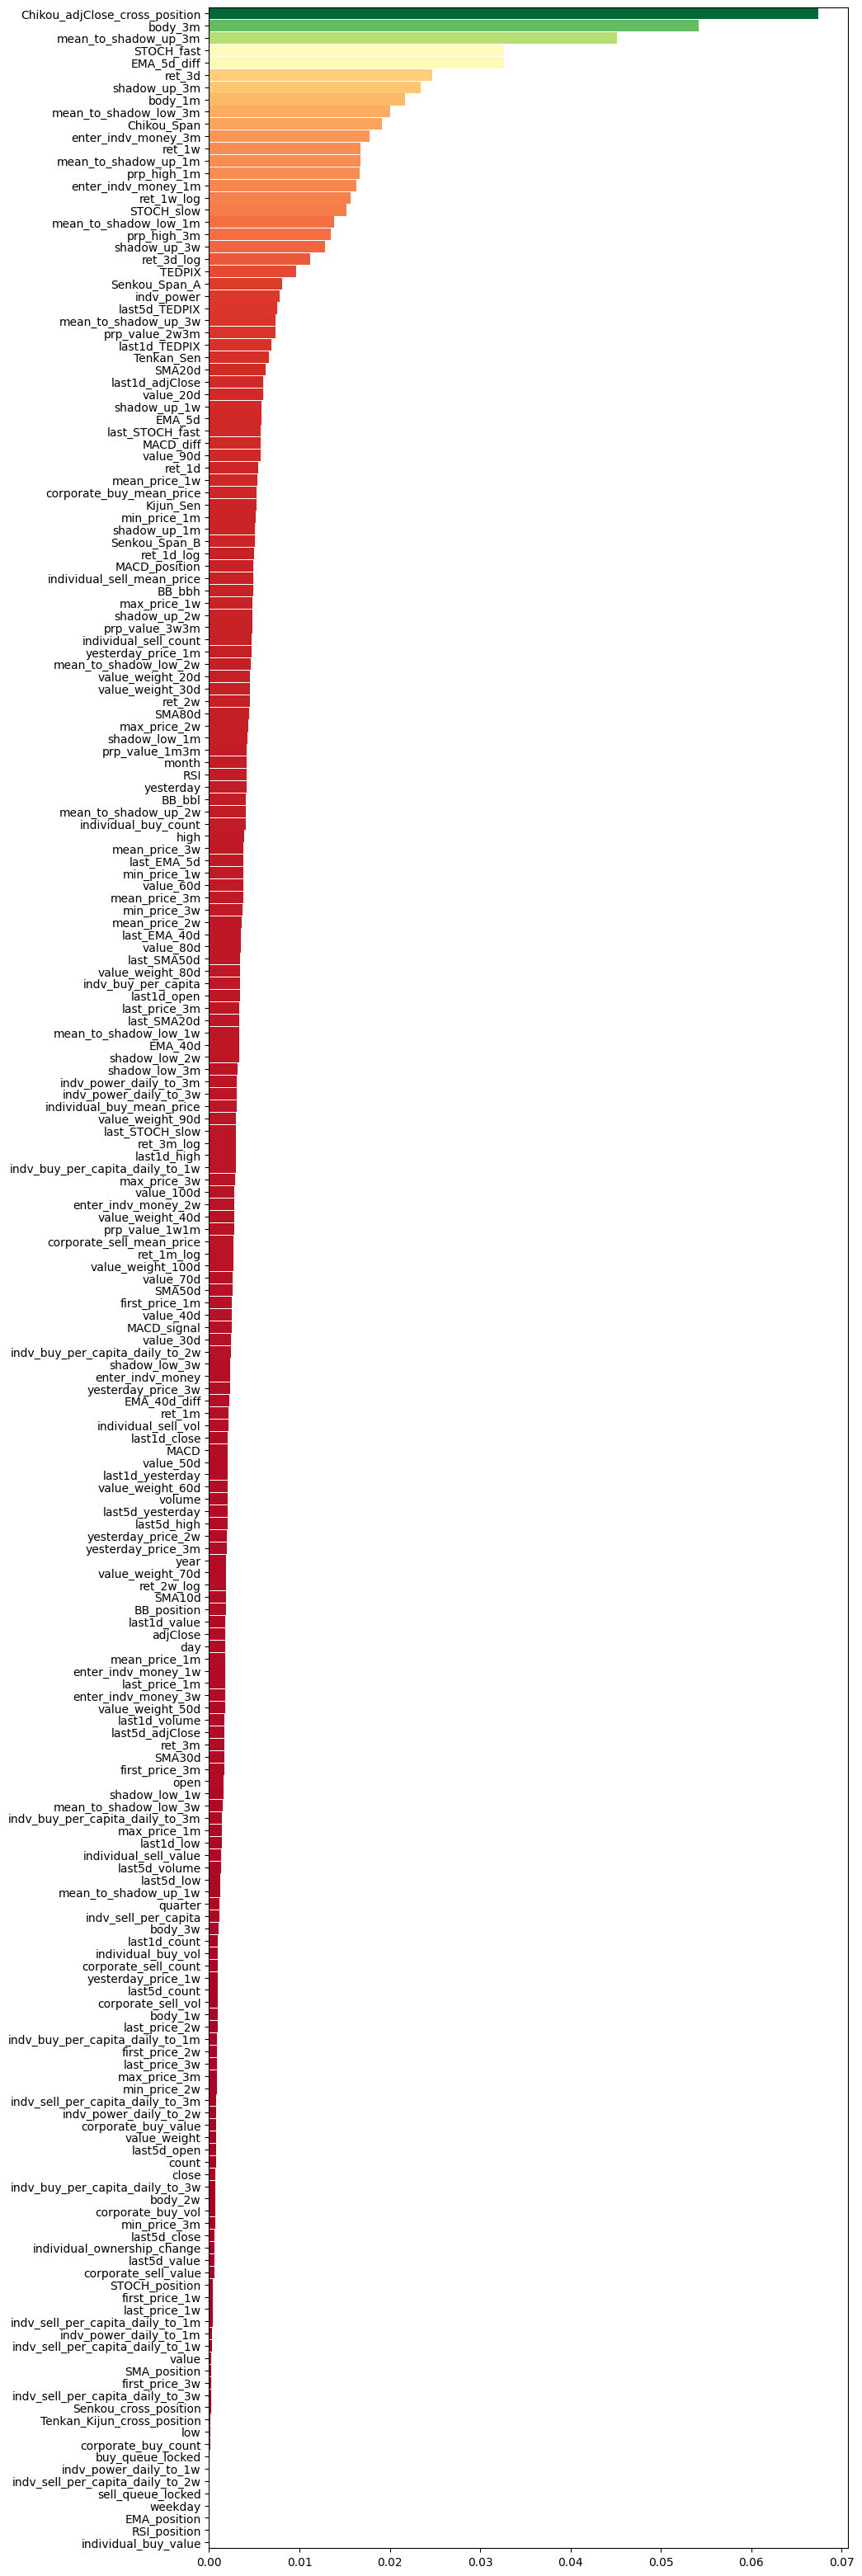

In [17]:
importance = pd.DataFrame(
    {
        'Features': initFeatures.iloc[:, 2:-1].columns,
        'Scores': featureImport
    }
).sort_values(by = ['Scores'])

plt.figure(figsize = (10, 40))
plt.tight_layout()

plt.barh(
    y = importance['Features'],
    width = importance['Scores'],
    height = 0.95,
    color = plt.cm.get_cmap('RdYlGn')(importance['Scores'] / max(importance['Scores']))
)
plt.margins(y=0)

In [18]:
def convertLabel(df, colName):
    name = str(colName + '01')
    df.loc[initFeatures[colName] == -1, name] = 0
    df[name] = df[name].fillna(1)
    return df
    
initFeatures['priChange'] = initFeatures['adjClose'] - initFeatures['yesterday']
labelPred = np.concatenate((trainPred, testPred), axis = 0)
initFeatures['labelPred'] = labelPred
labelProb = np.concatenate((trainProb, testProb), axis = 0)[:,1]
initFeatures['labelProb'] = labelProb

initFeatures = convertLabel(initFeatures, 'label')
initFeatures = convertLabel(initFeatures, 'labelPred')

initFeatures = initFeatures.merge(
    pivots,
    how = 'left',
    on = 'date'
)

initFeatures.head()

,jdate,date,open,high,low,adjClose,value,volume,count,yesterday,close,TEDPIX,year,quarter,month,day,weekday,shadow_up_1w,shadow_low_1w,body_1w,mean_to_shadow_up_1w,mean_to_shadow_low_1w,shadow_up_2w,shadow_low_2w,body_2w,mean_to_shadow_up_2w,mean_to_shadow_low_2w,shadow_up_3w,shadow_low_3w,body_3w,mean_to_shadow_up_3w,mean_to_shadow_low_3w,shadow_up_1m,shadow_low_1m,body_1m,mean_to_shadow_up_1m,mean_to_shadow_low_1m,shadow_up_3m,shadow_low_3m,body_3m,mean_to_shadow_up_3m,mean_to_shadow_low_3m,max_price_1w,min_price_1w,mean_price_1w,first_price_1w,last_price_1w,yesterday_price_1w,max_price_2w,min_price_2w,mean_price_2w,first_price_2w,last_price_2w,yesterday_price_2w,max_price_3w,min_price_3w,mean_price_3w,first_price_3w,last_price_3w,yesterday_price_3w,max_price_1m,min_price_1m,mean_price_1m,first_price_1m,last_price_1m,yesterday_price_1m,max_price_3m,min_price_3m,mean_price_3m,first_price_3m,last_price_3m,yesterday_price_3m,prp_high_1m,prp_high_3m,prp_value_1w1m,prp_value_2w3m,prp_value_3w3m,prp_value_1m3m,ret_1d,ret_3d,ret_1w,ret_2w,ret_1m,ret_3m,ret_1d_log,ret_3d_log,ret_1w_log,ret_2w_log,ret_1m_log,ret_3m_log,buy_queue_locked,sell_queue_locked,last1d_open,last1d_high,last1d_low,last1d_adjClose,last1d_value,last1d_volume,last1d_count,last1d_yesterday,last1d_close,last1d_TEDPIX,last5d_open,last5d_high,last5d_low,last5d_adjClose,last5d_value,last5d_volume,last5d_count,last5d_yesterday,last5d_close,last5d_TEDPIX,value_20d,value_30d,value_40d,value_50d,value_60d,value_70d,value_80d,value_90d,value_100d,value_weight,value_weight_20d,value_weight_30d,value_weight_40d,value_weight_50d,value_weight_60d,value_weight_70d,value_weight_80d,value_weight_90d,value_weight_100d,BB_bbh,BB_bbl,BB_position,Tenkan_Sen,Kijun_Sen,Chikou_Span,Senkou_Span_A,Senkou_Span_B,Tenkan_Kijun_cross_position,Senkou_cross_position,Chikou_adjClose_cross_position,EMA_5d,EMA_5d_diff,last_EMA_5d,EMA_40d,EMA_40d_diff,last_EMA_40d,EMA_position,MACD,MACD_diff,MACD_signal,MACD_position,SMA10d,SMA20d,last_SMA20d,SMA30d,SMA50d,last_SMA50d,SMA80d,SMA_position,STOCH_fast,STOCH_slow,last_STOCH_fast,last_STOCH_slow,STOCH_position,RSI,RSI_position,individual_buy_count,corporate_buy_count,individual_sell_count,corporate_sell_count,individual_buy_vol,corporate_buy_vol,individual_sell_vol,corporate_sell_vol,individual_buy_value,corporate_buy_value,individual_sell_value,corporate_sell_value,individual_buy_mean_price,individual_sell_mean_price,corporate_buy_mean_price,corporate_sell_mean_price,individual_ownership_change,enter_indv_money,indv_buy_per_capita,indv_sell_per_capita,indv_power,enter_indv_money_1w,indv_buy_per_capita_daily_to_1w,indv_sell_per_capita_daily_to_1w,indv_power_daily_to_1w,enter_indv_money_2w,indv_buy_per_capita_daily_to_2w,indv_sell_per_capita_daily_to_2w,indv_power_daily_to_2w,enter_indv_money_3w,indv_buy_per_capita_daily_to_3w,indv_sell_per_capita_daily_to_3w,indv_power_daily_to_3w,enter_indv_money_1m,indv_buy_per_capita_daily_to_1m,indv_sell_per_capita_daily_to_1m,indv_power_daily_to_1m,enter_indv_money_3m,indv_buy_per_capita_daily_to_3m,indv_sell_per_capita_daily_to_3m,indv_power_daily_to_3m,label,priChange,labelPred,labelProb,label01,labelPred01,pivots
0,1388-02-14,2009-05-04,14.0,15.0,14.0,15.0,3759836863,2080737,204,15.0,15.0,8638.3,1388,1,2,14,2,0.0,-0.066667,0.0000,0.000000,0.066667,0.0,-0.066667,0.000000,0.00000,0.066667,0.000000,-0.066667,0.000000,0.000000,0.066667,0.0000,-0.066667,0.066667,-0.057576,0.075758,0.071429,0.0,0.214286,-0.189223,0.096491,15.0,14.0,15.0,15.0,15.0,15.0,15.0,14.0,15.0,15.0,15.0,15.0,15.0,14.0,15.000000,15.0,15.0,15.0,16.0,14.0,15.136364,15.0,16.0,15.0,18.0,14.0,15.350877,14.0,17.0,14.0,1.071429,1.071429,0.349193,0.253204,0.326386,0.327252,0.000000,0.000000,0.000000,0.000000,0.004762,-0.045133,0.000000,0.000000,0.000000,0.000000,0.000000,-0.064539,0,0,15.0,15.0,14.0,15.0,2.382522e+09,1358340.0,147.0,15.0,14.0,8584.6,15.0,15.0,15.0,15.0,1.460205e+09,815360.0,122.0,15.0,15.0,8518.1,3.055976e+09,2.308920e+09,2.399035e+09,2.

Return in passive invesitng in train section: 6073%
Return in passive invesitng in test section: 707%
Max return in train section based on zigzag: 10633%
Max return in test section based on zigzag: 1966%
Return in train section based on prediction: 8640%
Return in test section based on prediction: 677%


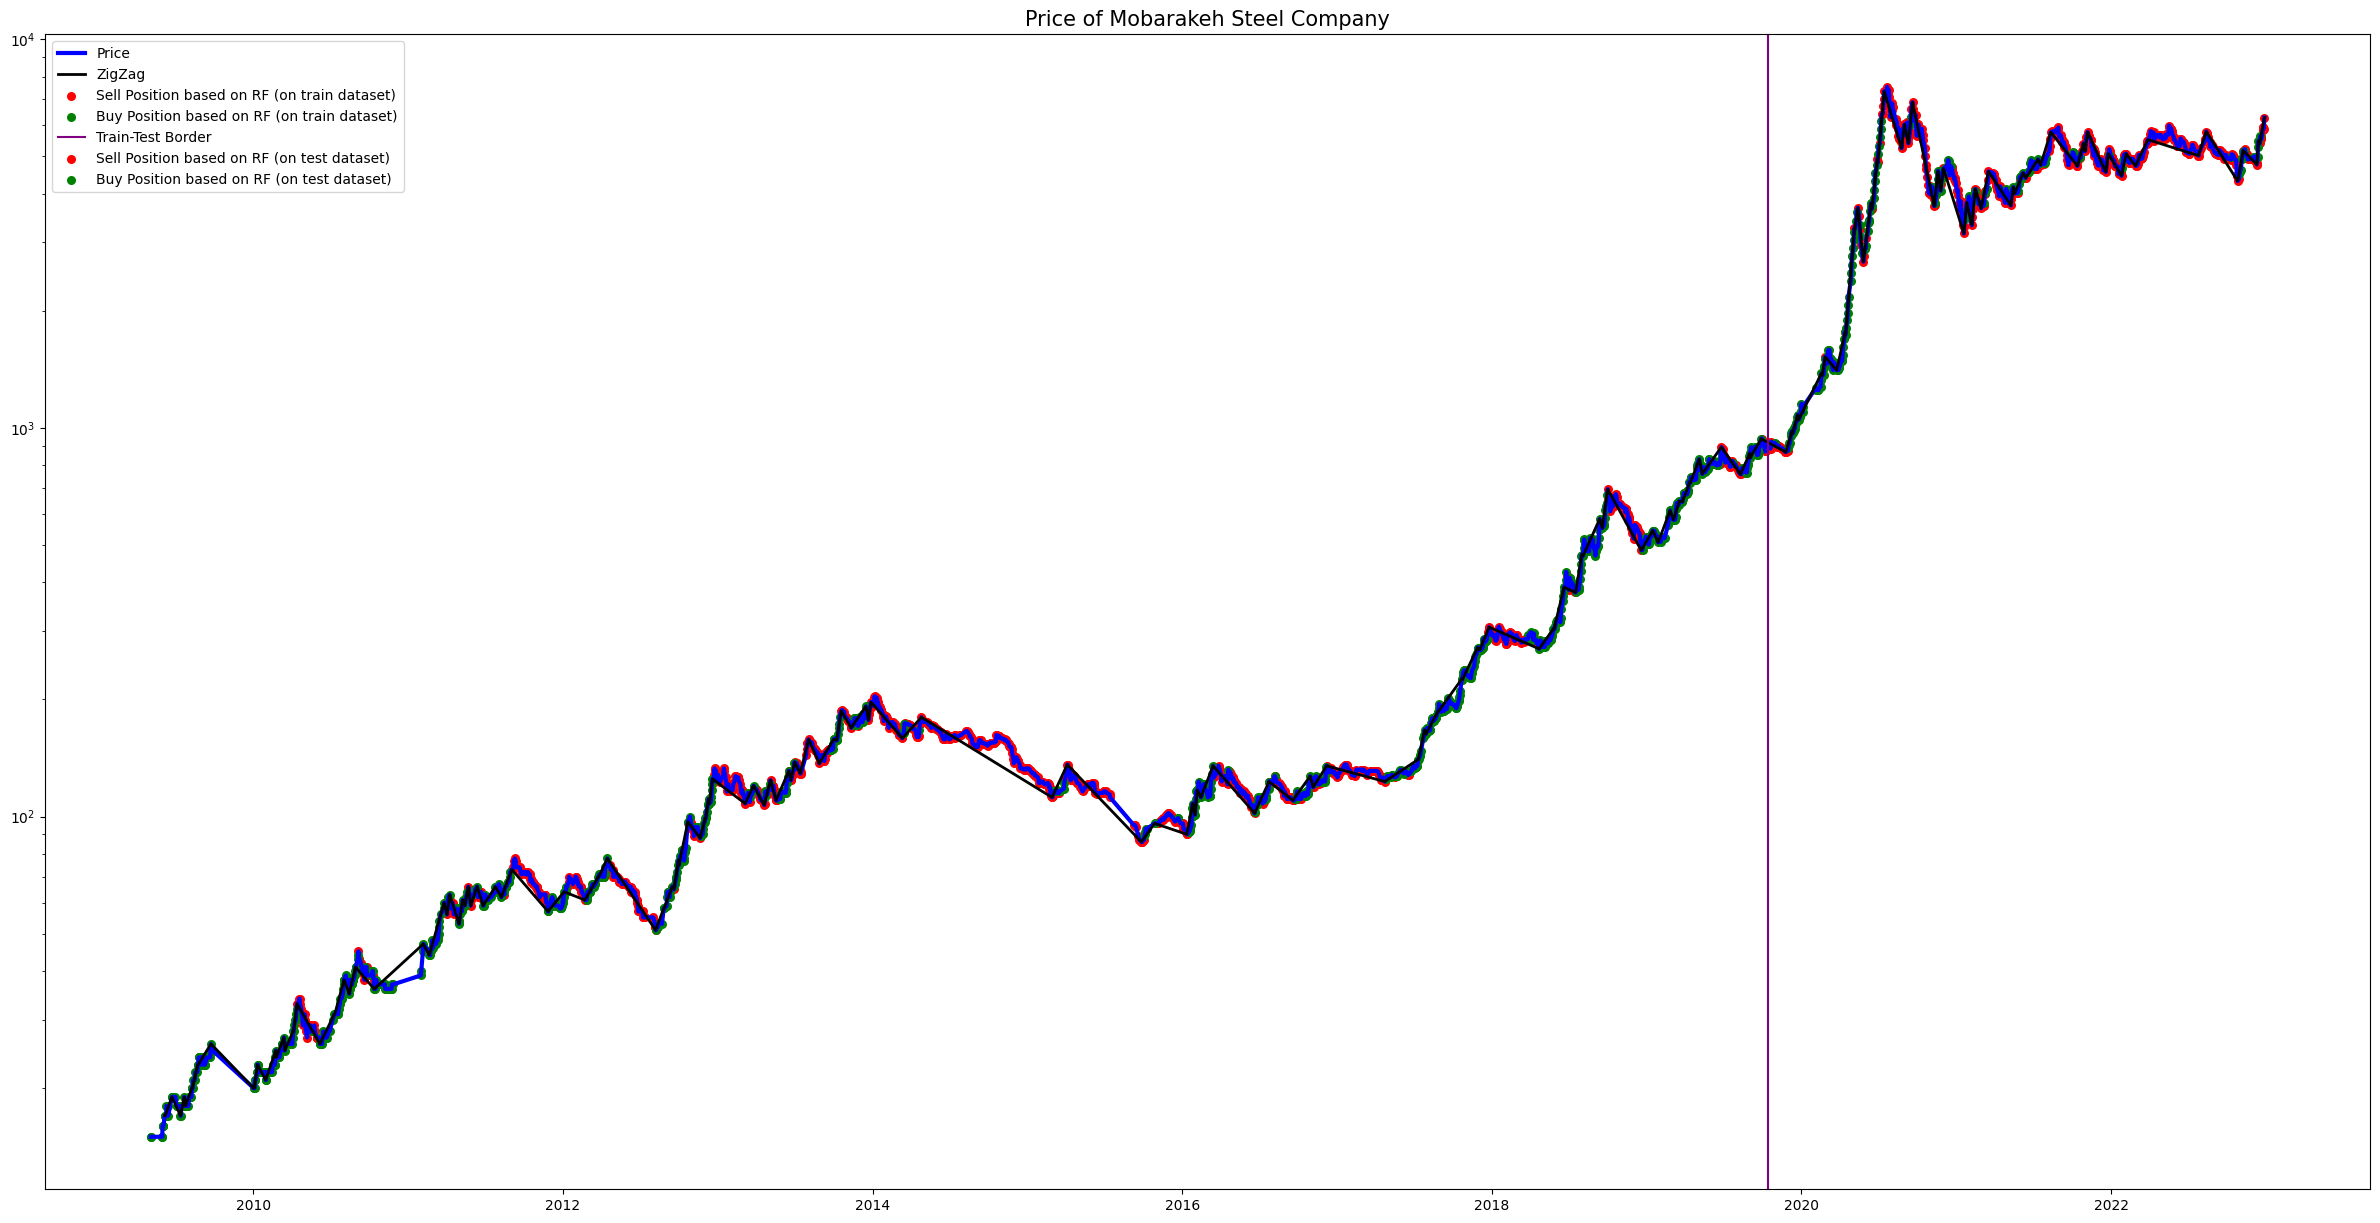

In [19]:
def plotLabel(df, trainPred, testPred):
    
    date = df['date']
    price = df['adjClose']
    label = df['label']
    neutralIndex = df['pivots'] == 0
    trainBuy = df.loc[df.index < len(trainPred)].loc[trainPred == 1].index 
    trainSell = df.loc[df.index < len(trainPred)].loc[trainPred == -1].index
    trainTestBorder = df.loc[df.index == len(trainPred)].index
    testBuy = df.loc[df.index >= len(trainPred)].loc[testPred == 1].index 
    testSell = df.loc[df.index >= len(trainPred)].loc[testPred == -1].index 
    
    plt.figure(figsize = (30, 15))
    plt.title('Price of Mobarakeh Steel Company', fontsize = 15)
    plt.plot(
        date,
        price,
        color = 'blue',
        lw = 3,
        label = 'Price'
    )    
    plt.plot(
        date.iloc[np.where(~neutralIndex)], 
        price.iloc[np.where(~neutralIndex)],
        color = 'black',
        lw = 2,
        label = 'ZigZag'
    )


    # train
    plt.scatter(
        date.iloc[trainSell] , 
        price.iloc[trainSell],
        color = 'red',
        s = 30,
        label = 'Sell Position based on RF (on train dataset)'
    )
    plt.scatter(
        date.iloc[trainBuy], 
        price.iloc[trainBuy],
        color = 'green',
        s = 30,
        label = 'Buy Position based on RF (on train dataset)'
    )
    plt.yscale('log')

    plt.axvline(date.iloc[trainTestBorder], color = 'purple', label = 'Train-Test Border')

    # test
    plt.scatter(
        date.iloc[testSell] , 
        price.iloc[testSell],
        color = 'red',
        s = 30,
        label = 'Sell Position based on RF (on test dataset)'
    )
    plt.scatter(
        date.iloc[testBuy], 
        price.iloc[testBuy],
        color = 'green',
        s = 30,
        label = 'Buy Position based on RF (on test dataset)'
    )
    plt.yscale('log')
    plt.legend()

print(f'Return in passive invesitng in train section: {(initFeatures["adjClose"].iloc[len(trainPred) - 1]  / initFeatures["adjClose"].iloc[0]):0.0%}')
print(f'Return in passive invesitng in test section: {(initFeatures["adjClose"].iloc[-1]  / initFeatures["adjClose"].iloc[len(trainPred)]):0.0%}')

print(f'Max return in train section based on zigzag: {((initFeatures["priChange"] * initFeatures["label01"].shift(2)).iloc[:len(trainPred)].sum() / initFeatures["adjClose"].iloc[0]):0.0%}')
print(f'Max return in test section based on zigzag: {((initFeatures["priChange"] * initFeatures["label01"].shift(2)).iloc[len(trainPred):].sum() / initFeatures["adjClose"].iloc[len(trainPred)]):0.0%}')

print(f'Return in train section based on prediction: {((initFeatures["priChange"] * initFeatures["labelPred01"].shift(2)).iloc[:len(trainPred)].sum() / initFeatures["adjClose"].iloc[0]):0.0%}')
print(f'Return in test section based on prediction: {((initFeatures["priChange"] * initFeatures["labelPred01"].shift(2)).iloc[len(trainPred):].sum() / initFeatures["adjClose"].iloc[len(trainPred)]):0.0%}')
plotLabel(initFeatures, trainPred, testPred)

# Bayesian Optimization

In [20]:
# def rfcScore(
#     n_estimators,
#     min_samples_split,
#     min_samples_leaf,
#     max_depth):
    
#     n_estimators = int(n_estimators)
#     min_samples_split = int(min_samples_split)
#     min_samples_leaf = int(min_samples_leaf)
#     max_depth = int(max_depth)
    
#     params = {
#         'n_estimators': n_estimators,
#         'criterion': 'entropy',
#         'min_samples_split': min_samples_split,
#         'min_samples_leaf': min_samples_leaf,
#         'max_depth': max_depth,
#         'max_features': 'sqrt',
#         'n_jobs': -1,
#         'random_state': 1,
#         'class_weight': 'balanced_subsample'
#     }

#     rfc = RandomForestClassifier(
#         **params
#     )

#     score = cross_val_score(
#         rfc, 
#         X = X_train,
#         y = y_train,
#         scoring = 'f1_weighted'
#     ).mean()

#     return score

# def RFClf(train_data, train_label, test_data, test_label, params):
    
#     clf = RandomForestClassifier(
#         n_estimators = int(params['n_estimators']),
#         max_depth = int(params['max_depth']),
#         min_samples_leaf = int(params['min_samples_leaf']),
#         min_samples_split = int(params['min_samples_split']),
#         criterion = 'entropy',
#         class_weight = 'balanced_subsample',
#         random_state = 0
#     )

#     clf.fit(train_data, train_label)
    
#     trainPred = clf.predict(train_data)
#     testPred = clf.predict(test_data)

#     trainProb = clf.predict_proba(train_data)
#     testProb = clf.predict_proba(test_data)

#     featureImport = clf.feature_importances_

#     trainClassReport = metrics.classification_report(train_label, trainPred)
#     testClassReport = metrics.classification_report(test_label, testPred)

#     return trainPred, testPred, trainProb, testProb, featureImport, trainClassReport, testClassReport

# rfcBound = {
#     'n_estimators': (100, 200),
#     'min_samples_split': (2, 5),
#     'min_samples_leaf': (1, 5),
#     'max_depth': (4, 8)
# }
# optimizer = BayesianOptimization(
#     f = rfcScore, 
#     pbounds = rfcBound,
#     random_state = 1
# )
# optimizer.maximize(
#     init_points = 3,
#     n_iter = 5,
# )

# print(f"Selected parameters: {optimizer.max['params']}\n")

# trainPred, testPred, trainProb, testProb, featureImport, trainClassReport, testClassReport = RFClf(X_train, y_train, X_test, y_test, optimizer.max['params'])

# print(f'Training classification report:\n{trainClassReport}')
# print(f'Testing classification report:\n{testClassReport}')